In [ ]:
import os
import pandas as pd #importing pandas library
import matplotlib.pyplot as plt #importing matplotlib
from scipy.spatial import distance_matrix #import the distance_matrix function
from scipy.cluster.hierarchy import linkage,dendrogram #import linkage and dendrogram function
from sklearn.cluster import AgglomerativeClustering,KMeans #importing clustering function
from sklearn.linear_model import SGDClassifier #importing the SGDClassifier
from sklearn.model_selection import train_test_split,ParameterGrid,GridSearchCV #importing the parameter grid and gridsearch function
import numpy as np #import numpy library
from sklearn.neighbors import KNeighborsClassifier #importing the KnearestNeighborsClassifier
from pandas.core.common import random_state #importing the randomstate functino
from sklearn.tree import DecisionTreeClassifier #importing the Decision Tree Classifier
from sklearn.ensemble import RandomForestClassifier #importing the random forest Classifier
from sklearn.tree import export_graphviz #importing the tree visualizer
from IPython.display import Image #importing the library to display images
from sklearn.metrics import accuracy_score,roc_auc_score ,precision_recall_curve, PrecisionRecallDisplay,plot_roc_curve, ConfusionMatrixDisplay,confusion_matrix #importing the different metrics to choose between the models
%matplotlib inline

In [ ]:
os.chdir('/content') #while we are using collab, let's make the same environemnet for everybody 
#if you are using jupyter you might have to change the path '/content' but your working place

In [ ]:
os.getcwd() #print the current working directory

'/content'

In [ ]:
df_orig=pd.read_csv('spotify_dataset.csv')

In [ ]:
print(df_orig.head(),df_orig.shape) #printing the 5 first values of the dataset


                   track            artist  ... popularity  decade
0  Jealous Kind Of Fella     Garland Green  ...          1     60s
1          Initials B.B.  Serge Gainsbourg  ...          0     60s
2           Melody Twist       Lord Melody  ...          0     60s
3          Mi Bomba Sonó        Celia Cruz  ...          0     60s
4            Uravu Solla       P. Susheela  ...          0     60s

[5 rows x 20 columns] (41099, 20)


In [ ]:
display(df_orig.info()) #determine the different columns and their types

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41099 entries, 0 to 41098
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track             41099 non-null  object 
 1   artist            41099 non-null  object 
 2   uri               41099 non-null  object 
 3   danceability      41099 non-null  float64
 4   energy            41099 non-null  float64
 5   key               41099 non-null  int64  
 6   loudness          41099 non-null  float64
 7   mode              41099 non-null  int64  
 8   speechiness       41099 non-null  float64
 9   acousticness      41099 non-null  float64
 10  instrumentalness  41099 non-null  float64
 11  liveness          41099 non-null  float64
 12  valence           41099 non-null  float64
 13  tempo             41099 non-null  float64
 14  duration_ms       41099 non-null  int64  
 15  time_signature    41099 non-null  int64  
 16  chorus_hit        41099 non-null  float6

None

Because we won't treat NLP we will drop the columns about the name of the artist, the song and the url since they are not relevant for our study

In [ ]:
columns_to_drop=['track','artist','uri','decade'] #creating a list to select the differents columns to drop
df=df_orig.drop(columns=columns_to_drop) #droping those columns
df.shape #printing the shape of the dataframe in order to verify its dimension

(41099, 16)

Since the dimension of our dataframe was reduced by 4 we have dropped the choosen columns. now let's see if there is binary classes in the dataframe

In [ ]:
Binary=[] #creating an empty list
for i in df.columns: #create a loop to go through all columns
  if len(df[i].value_counts()) < 3 : #creating the condition to have binary classes only
    print(i,df[i].value_counts()) #printing the different binary classes and their repartition of values
    Binary.append(i) #appending the column name in the binary list
print('Here is the binary classes : ' + str(Binary)) #printing it in order to visualize better the informations
df[Binary] #display the dataframe with the different binary column

mode 1    28497
0    12602
Name: mode, dtype: int64
popularity 0    20551
1    20548
Name: popularity, dtype: int64
Here is the binary classes : ['mode', 'popularity']


,mode,popularity
0,1,1
1,1,0
2,1,0
3,0,0
4,0,0
...,...,...
41094,1,0
41095,1,1
41096,1,1
41097,1,0


now that we have our dataset columns cleaned and all the datas that we could be able to use, we will focus on cleaning the data and see if there is any outliers. we can also see that our dataset is balanced concerning the popularity, hence it will be easier for us to avoid underfitting or overfitting in the future.

In [ ]:
L=df.columns.to_list() #takings all the different columns name
def histo(column): #creating the function for the histogram
  plt.hist(df[column],bins=50) #plotting the histogram with the intervals divided into 50 equal size bins
  plt.title(column) #setting up the title as the name of the column
  plt.savefig('Histogram of : ' +str(column), dpi=300) #saving the figures
  plt.show() #printing the different figures

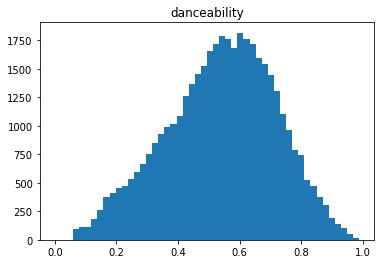

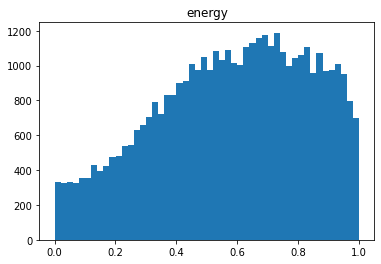

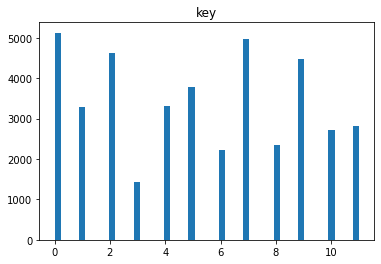

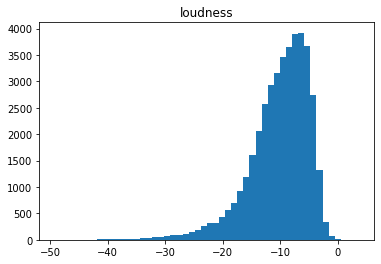

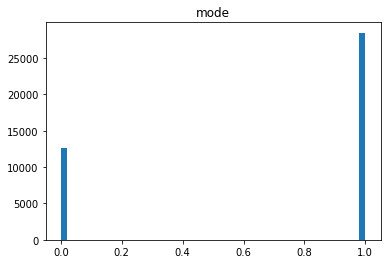

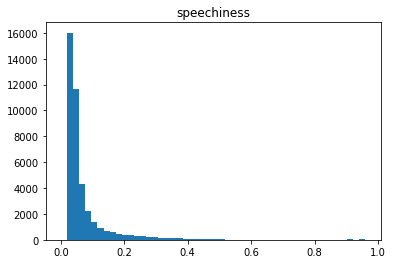

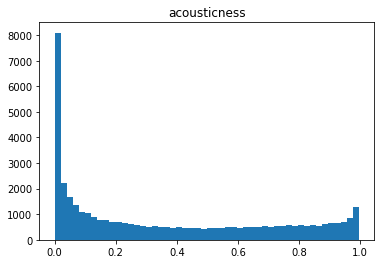

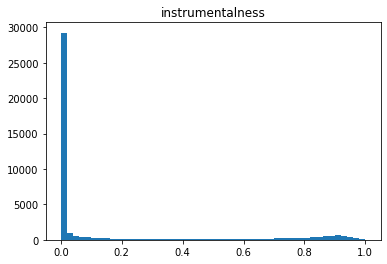

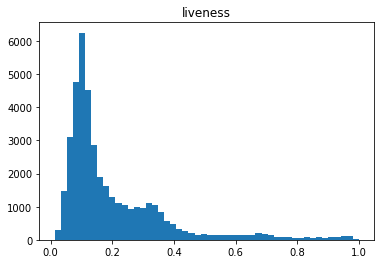

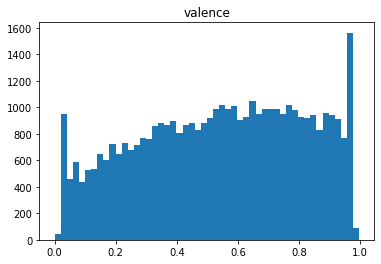

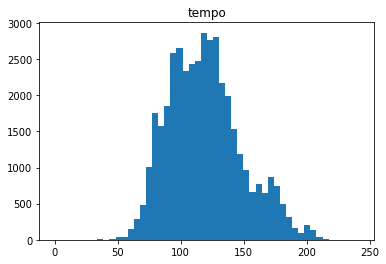

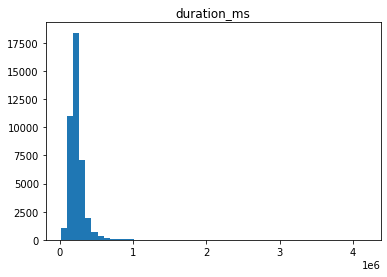

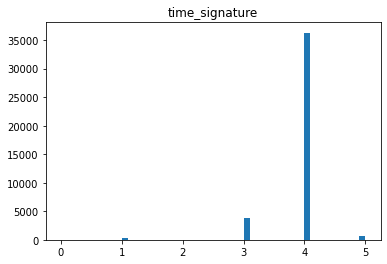

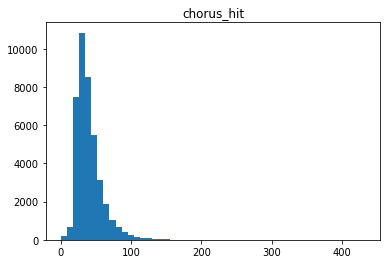

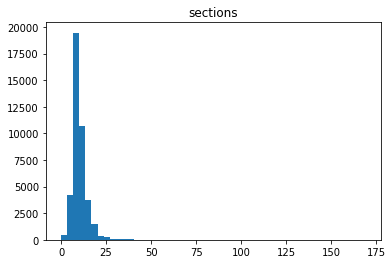

In [ ]:
for i in L[:-1]: #creating a list with all the columns
  histo(i) #boxplotting the different columns

Now we know how each feature is skewed, hence we can see how our dataset is composed, we can now analyse the correlation between the different features

In [ ]:
df.corr() #getting the dataframe of the different correlation between columns

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,popularity
danceability,1.000000,0.206036,0.015433,0.273997,-0.032740,0.156362,-0.261122,-0.301834,-0.115275,0.553845,-0.066588,-0.062915,0.191814,-0.036227,-0.058528,0.346020
energy,0.206036,1.000000,0.022598,0.772611,-0.033907,0.122360,-0.715084,-0.208113,0.157797,0.341398,0.224107,0.011961,0.196221,0.009660,-0.040129,0.177117
key,0.015433,0.022598,1.000000,0.008483,-0.140398,0.026554,-0.024240,-0.013120,0.000639,0.007748,0.001116,0.015480,0.004756,0.010262,0.006771,0.009923
loudness,0.273997,0.772611,0.008483,1.000000,0.000384,0.069115,-0.566503,-0.374206,0.086676,0.271706,0.169506,-0.049733,0.165748,-0.013371,-0.079946,0.285972
mode,-0.032740,-0.033907,-0.140398,0.000384,1.000000,-0.059758,0.050028,-0.075968,0.008781,0.035613,0.027088,-0.074744,-0.009387,-0.022604,-0.057016,0.079633
speechiness,0.156362,0.122360,0.026554,0.069115,-0.059758,1.000000,-0.083843,-0.084067,0.131381,0.001521,0.036730,0.007708,0.021087,0.012990,-0.008572,-0.040936
acousticness,-0.261122,-0.715084,-0.024240,-0.566503,0.050028,-0.083843,1.000000,0.204083,-0.030731,-0.195296,-0.179719,-0.070389,-0.188242,-0.012468,-0.016917,-0.245952
instrumentalness,-0.301834,-0.208113,-0.013120,-0.374206,-0.075968,-0.084067,0.204083,1.000000,-0.050554,-0.286977,-0.053595,0.106511,-0.078140,0.048695,0.081167,-0.407560
liveness,-0.115275,0.157797,0.000639,0.086676,0.008781,0.131381,-0.030731,-0.050554,1.000000,0.000804,0.024766,0.005373,0.004804,0.037968,-0.011708,-0.051484
valence,0.553845,0.341398,0.007748,0.271706,0.035613,0.001521,-0.195296,-0.286977,0.000804,1.000000,0.107952,-0.172097,0.155806,-0.059120,-0.133476,0.251117


In [ ]:
corre=df.corr().iloc[-1].sort_values(ascending=False) #selecting the popularity row and display the values by descending order
corre #printing it

popularity          1.000000
danceability        0.346020
loudness            0.285972
valence             0.251117
energy              0.177117
time_signature      0.104941
mode                0.079633
tempo               0.032582
key                 0.009923
speechiness        -0.040936
chorus_hit         -0.046416
liveness           -0.051484
sections           -0.059993
duration_ms        -0.073806
acousticness       -0.245952
instrumentalness   -0.407560
Name: popularity, dtype: float64

Since our target is popularity it doesn't make sense to take it into account so we will drop the first line of corre

In [ ]:
corre=corre.drop('popularity') #dropping the Correlation row
corre #printing the new dataframe of correlation

danceability        0.346020
loudness            0.285972
valence             0.251117
energy              0.177117
time_signature      0.104941
mode                0.079633
tempo               0.032582
key                 0.009923
speechiness        -0.040936
chorus_hit         -0.046416
liveness           -0.051484
sections           -0.059993
duration_ms        -0.073806
acousticness       -0.245952
instrumentalness   -0.407560
Name: popularity, dtype: float64

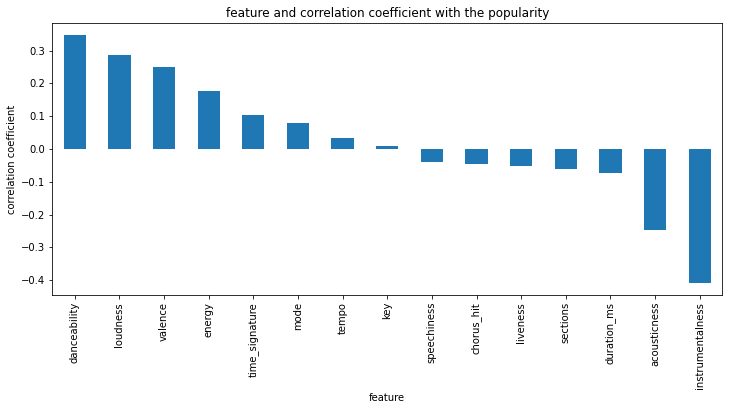

In [ ]:
plt.figure(figsize=(12, 5)) #setting the figure size
labels = [f"{i}" for i in corre.index.to_list()] #extracting the different label
ax = corre.plot(kind="bar") #ploting the different bars
ax.set_title("feature and correlation coefficient with the popularity") #setting the tittle
ax.set_xlabel("feature") #setting de x labels
ax.set_ylabel("correlation coefficient") #setting the y label
ax.set_xticklabels(labels) # setting the x ticks labels
plt.savefig('Feature and correlation coefficient for popularity',dpi=300) #saving the figure
plt.show() #showing the graph


Since the correlation are not so significant we won't drop any columns or concentrate on any one. Now lets make an exploration of the dataset ! Using different unsepervised programm in order to find some paterns

In [ ]:
dfexp=df.copy() #creating a copy of the dataframe
X_train, X_test = train_test_split(dfexp,test_size=0.025, random_state=42, shuffle=True, stratify=df['popularity']) #splitting into different values in order to go quicker in the computation selecting only 2.5% of the data
X_test.shape #printing X shape

(1028, 16)

In [ ]:
distmatr=pd.DataFrame(distance_matrix(X_test.values, X_test.values), index=X_test.index, columns=X_test.index) #compute the distance matrix
distmatr #computation of the distmatr

,3971,35077,40746,7655,21091,16000,10416,8922,28303,16241,311,24083,29993,29175,27181,16757,28976,34664,36074,7928,34675,39236,25575,5658,4800,8010,8873,5755,28538,28714,30447,16343,20306,21665,24933,32860,1662,1386,11027,7488,...,6569,9145,35436,32347,22041,25873,24753,2697,31145,36443,29783,21094,23710,2067,10297,22596,13317,1826,9037,29343,34416,18312,16338,40775,8257,36886,18879,2503,25647,40651,33787,38991,33588,15575,15665,7986,11119,15251,19583,288
3971,0.000000,157000.007153,228146.006723,228693.000529,49110.067157,302680.000761,228133.000383,54773.014201,148200.001392,219413.005041,34066.002202,172133.002138,176026.005576,183066.000789,80133.002673,156746.002345,265506.000270,189533.000856,176546.000985,233973.004241,192666.020300,188933.000901,271000.026826,229533.001772,38920.085670,210733.003175,242726.010215,260093.003409,150506.013066,125093.008063,238821.002222,140680.004518,156373.006537,47321.006160,175640.010527,205666.001051,338640.000460,233893.000443,261226.001782,257920.002296,...,166400.000222,235466.003181,156666.000527,148160.000733,198040.002674,179293.001776,156533.002659,288960.002992,189973.004372,99226.004882,157653.007315,30360.054239,204906.000633,78066.051562,221240.000240,132346.000767,57826.058448,210627.008994,157133.004709,177706.000609,286013.003245,169720.003647,189306.001083,206333.004199,237000.001946,138196.020391,248853.008987,270133.003249,152866.025341,132026.000711,381026.003430,178693.008048,213306.000581,148693.025699,218800.030587,167613.004258,115346.005969,293677.003763,163733.007548,277840.007127
35077,157000.007153,0.000000,71146.000573,71693.015192,107890.006229,459680.001276,71133.010852,102227.016532,8800.194301,62413.000929,122934.009082,15133.031403,19026.000791,26066.023181,76867.005617,255.836505,108506.008888,32533.029896,19546.037752,76973.002886,35666.035153,31933.015540,114000.024729,72533.004228,195920.008038,53733.002127,85726.009007,103093.002306,6494.025550,31907.000701,81821.002022,16320.005896,627.097926,109679.004064,18640.008206,48666.035039,181640.007590,76893.009484,104226.003490,100920.001641,...,9400.093628,78466.003836,337.593894,8840.074033,41040.003185,22293.013982,468.787033,131960.018738,32973.002216,57774.002486,653.072773,187360.000616,47906.013857,78934.012151,64240.019671,24654.029973,99174.007831,53627.012095,134.316030,20706.048904,129013.026394,12720.008366,32306.017837,49333.000463,80000.002212,18804.022118,91853.002994,113133.004500,4134.212971,24974.036299,224026.002472,21693.001482,56306.015160,8307.181338,61800.038771,10613.012866,41654.002004,136677.005950,6733.013902,120840.001477
40746,228146.006723,71146.000573,0.000000,549.719039,179036.002598,530826.001632,49.379113,173373.012257,79946.027102,8733.013396,194080.007963,56013.013514,52120.001725,45080.020785,148013.004595,71400.010212,37360.036490,38613.034381,51600.020310,5827.055042,35480.030273,39213.020167,42854.054269,1387.395252,267066.005695,17413.014457,14580.051959,31947.011500,77640.000977,103053.000600,10675.031342,87466.002628,71773.001787,180825.003806,52506.002219,22480.097758,110494.016449,5747.187281,33080.017700,29774.010693,...,61746.020159,7320.064827,71480.022606,79986.012097,30106.009808,48853.010807,71613.016009,60814.049567,38173.004166,128920.002489,70493.001281,258506.000232,23240.041520,150080.004397,6906.243629,95800.011405,170320.003169,17519.038897,71013.004451,50440.028151,57867.070399,58426.004177,38840.022129,21813.004865,8854.042204,89950.002313,20707.008008,41987.016917,75280.007820,96120.013097,152880.004305,49453.000082,14840.083396,79453.017391,9346.201633,60533.004937,112800.001694,65531.015782,64413.002324,49694.002451
7655,228693.000529,71693.015192,549.719039,0.000000,179583.017816,531373.000505,560.232052,173920.002273,80493.005646,9280.101150,194627.000404,56560.003664,52667.017493,45627.003144,148560.002378,71947.002725,36813.002979,39160.007666,52147.004766,5280.141659,36027.094828,39760.003816,42307.163147,840.397263,267613.010245,17960

if we dont select the 2.5% of data, it will compute for more than 30 minutes and create a file of 28 GO, that's why we have choosen to do that even if it could create bias

In [ ]:
X_test['popularity'].value_counts() #Testing the popularity balance

0    514
1    514
Name: popularity, dtype: int64

In [ ]:
row_clusters=linkage(distmatr,method='complete',metric='euclidean') #compute the linkage

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  """Entry point for launching an IPython kernel.


{'color_list': ['g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',

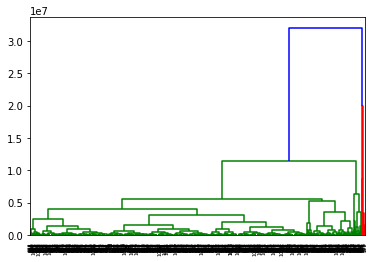

In [ ]:
dendrogram(row_clusters) #showing the dendrogram

Even if we have computed the dendrogram, we won't be able to use it because it seems non relevant for our study (we cannot have insights with this classification in this case)

In [ ]:
mod = AgglomerativeClustering(n_clusters=15, affinity="euclidean", linkage="complete") #using agglomerative clustering

In [ ]:
y_pred=mod.fit_predict(X_test) #predicting the different labels
y_pred #printing the predictions

array([ 0,  8,  4, ..., 12,  8, 12])

In [ ]:
pd.DataFrame(y_pred).value_counts() #counting the different predictions

4     362
8     211
6     142
14     85
10     80
12     48
0      45
3      19
2      14
1       6
9       6
7       5
5       3
11      1
13      1
dtype: int64

Since some class are with only 1 value we consider it to be non relevant and it cannot give any insights so we won't exploit this kind of clustering

In [ ]:
def Elbowmethod(Nclass): #creating an elbow method graph to decide how many cluster we will have in our k mean function
  inertias = [] #creating an empty list that will collect the different inertias
  mapping2 = {} 
  K = range(1, Nclass) #creating the different clusters values list
  for k in K: #creating the loop
    # fitting and building the model
    kmeanModel = KMeans(n_clusters=k).fit(X_test) #fitting
    inertias.append(kmeanModel.inertia_) #collecting inertias informations
    mapping2[k] = kmeanModel.inertia_ #dictionnary that will print out the different inertias
  for key, val in mapping2.items(): #printing the different values 
    print(f'{key} : {val}')
  plt.plot(K, inertias, 'bx-') #ploting the graph
  plt.xlabel('K-value') #changing the x labels
  plt.ylabel('Inertia') #changing y labels
  plt.title('Elbow method on Inertia') #setting the tittle
  plt.show() #showing the graph

1 : 9861760378325.12
2 : 5025787410675.234
3 : 2590723792031.2144
4 : 1646161575304.295
5 : 1218105897093.6401
6 : 848834873878.8772
7 : 620301563789.4597
8 : 482757685973.88544
9 : 374584347723.30176
10 : 290544108069.6465
11 : 236426467105.69128
12 : 192470654395.05063
13 : 151313946743.4763
14 : 131675715657.7314
15 : 115266046183.9217
16 : 98902146750.84787
17 : 85519845116.31934
18 : 76013088075.13788
19 : 66919245665.04932


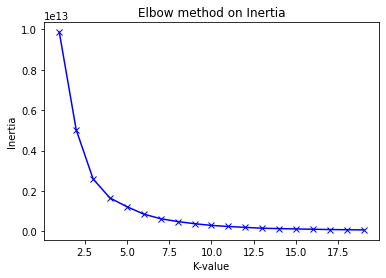

In [ ]:
Elbowmethod(20) #applying the elbow method on the first 20 clusters

Using the elbow method, we can set the number of cluster to 8 in order to use unsupervised learning to discover patterns in our dataset.

In [ ]:
kmeanModel = KMeans(n_clusters=8,random_state=42) #setting up the kmean model
Difclass=kmeanModel.fit_predict(X_train) #selecting the different class


In [ ]:
exploratorydf=X_train #setting up the exploratory dataframe with less data
exploratorydf['Difclass']=Difclass #creating the new column containing the prediction
difclass=[] #creating a difclass list that will gather all the different classes
for k in range(8):
  filtered_df=exploratorydf[exploratorydf['Difclass']==k] #creating a filtered dataframe
  difclass.append(filtered_df)  #append all the filtered in the list

This is the popularity repartition in the catégory 0
 0    4194
1    2297
Name: popularity, dtype: int64
This is the normalized popularity repartition in the catégory 0
 0    0.646125
1    0.353875
Name: popularity, dtype: float64


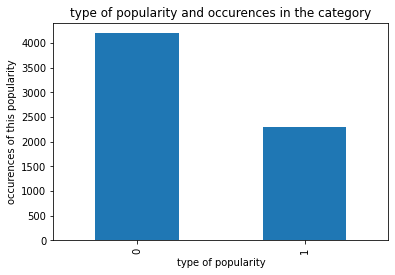

This is the popularity repartition in the catégory 1
 0    3169
1    2852
Name: popularity, dtype: int64
This is the normalized popularity repartition in the catégory 1
 0    0.526325
1    0.473675
Name: popularity, dtype: float64


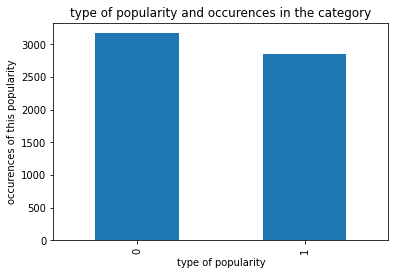

This is the popularity repartition in the catégory 2
 1    6652
0    5747
Name: popularity, dtype: int64
This is the normalized popularity repartition in the catégory 2
 0    0.463505
1    0.536495
Name: popularity, dtype: float64


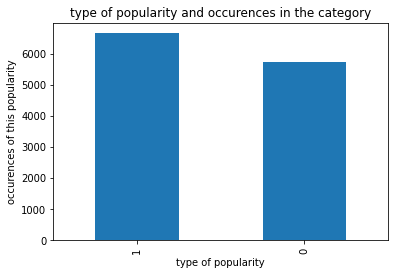

This is the popularity repartition in the catégory 3
 0    443
1     34
Name: popularity, dtype: int64
This is the normalized popularity repartition in the catégory 3
 0    0.928721
1    0.071279
Name: popularity, dtype: float64


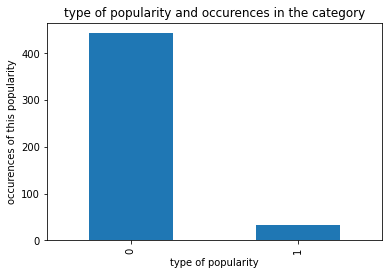

This is the popularity repartition in the catégory 4
 0    1525
1     457
Name: popularity, dtype: int64
This is the normalized popularity repartition in the catégory 4
 0    0.769425
1    0.230575
Name: popularity, dtype: float64


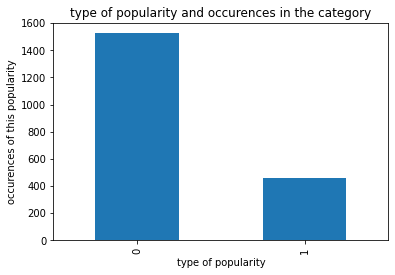

This is the popularity repartition in the catégory 5
 0    7
Name: popularity, dtype: int64
This is the normalized popularity repartition in the catégory 5
 0    1.0
Name: popularity, dtype: float64


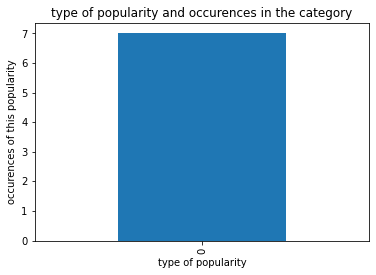

This is the popularity repartition in the catégory 6
 1    7738
0    4830
Name: popularity, dtype: int64
This is the normalized popularity repartition in the catégory 6
 0    0.384309
1    0.615691
Name: popularity, dtype: float64


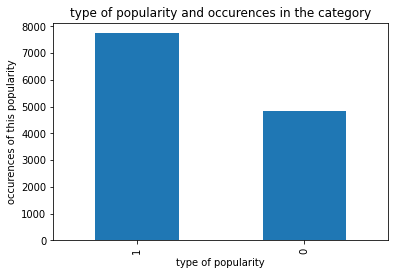

This is the popularity repartition in the catégory 7
 0    122
1      4
Name: popularity, dtype: int64
This is the normalized popularity repartition in the catégory 7
 0    0.968254
1    0.031746
Name: popularity, dtype: float64


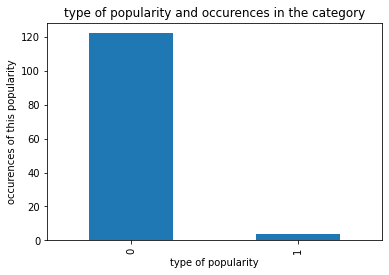

In [ ]:
hitrep=[] #creating a list that will contain the hit repartition
hitreprelative=[] #creating a list that will contain the hit relative repartition
Liston1 = [] #creating a list that will stock every relative repetition of 1
for k in range(0,len(difclass)): #creating the loop
  hitrep.append(difclass[k]['popularity'].value_counts()) #counting the different values and appending the value in the list
  hitrepdf=difclass[k]['popularity'].value_counts() #counting the different values and making it as a dataFrame
  hitreprelative.append(difclass[k]['popularity'].value_counts(normalize=True)) #counting the different relative values and appending the value in the list
  hitrepdfrelative=difclass[k]['popularity'].value_counts(normalize=True).sort_index() #counting the different relatives values and making it as a DataFrame and sorting it on index to have the same organization on all the different classes
  if hitrepdfrelative.shape[0]==2: #creating the different condtions to add or not the value in order to sort it at the end and get index of the 4 most reprensented (in relative value) popular songs
    Liston1.append(hitrepdfrelative[1])
  elif hitrepdfrelative.index[0]==0:
    Liston1.append(0)
  else :
    Liston1.append(hitrepdfrelative[0])
  print('This is the popularity repartition in the catégory '+ str(k) +'\n',difclass[k]['popularity'].value_counts()) #displaying the result 
  print('This is the normalized popularity repartition in the catégory '+ str(k) +'\n',hitrepdfrelative) #displaying the result on a representative way
  labels = [f"{i}" for i in hitrepdf.index.to_list()] #creating the different labels for each graphs
  ax = hitrepdf.plot(kind="bar") #plotting the different columns
  ax.set_title("type of popularity and occurences in the category") #setting the title of the different columns
  ax.set_xlabel("type of popularity") #settting up x label title
  ax.set_ylabel("occurences of this popularity") #setting up y label title
  ax.set_xticklabels(labels) #setting x ticks with the name of each feature
  plt.show() #display the graphs
listmax=np.flip(np.argsort(Liston1)) #getting index in descending order of the 1 value in representation

In order to find patterns about the most popular musics we will now visualize the different values of the columns we will sum up the different informations and plot them. we will choose the 4 biggest values of percentage of 1. In order to visualize the things that makes a song less popular we will visualize the other class

this is the description of the category 0
        danceability       energy  ...   popularity  Difclass
count   6491.000000  6491.000000  ...  6491.000000    6491.0
mean       0.502908     0.501583  ...     0.353875       0.0
std        0.175835     0.269445  ...     0.478208       0.0
min        0.062500     0.000251  ...     0.000000       0.0
25%        0.379000     0.288000  ...     0.000000       0.0
50%        0.517000     0.496000  ...     0.000000       0.0
75%        0.633000     0.715000  ...     1.000000       0.0
max        0.981000     1.000000  ...     1.000000       0.0

[8 rows x 17 columns]


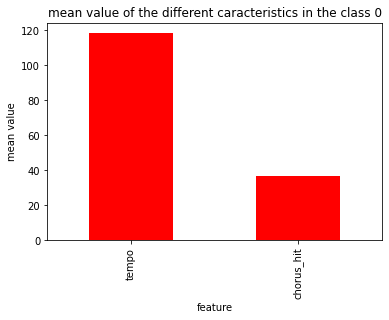

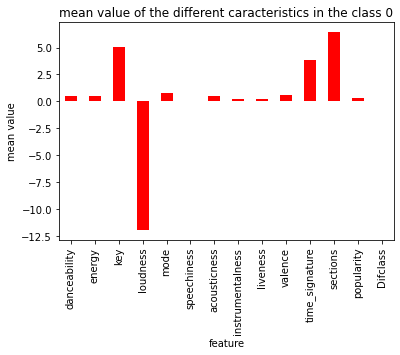

this is the description of the category 1
        danceability       energy  ...   popularity  Difclass
count   6021.000000  6021.000000  ...  6021.000000    6021.0
mean       0.545735     0.610822  ...     0.473675       1.0
std        0.182640     0.243667  ...     0.499348       0.0
min        0.062000     0.001100  ...     0.000000       1.0
25%        0.420000     0.444000  ...     0.000000       1.0
50%        0.556000     0.640000  ...     0.000000       1.0
75%        0.684000     0.808000  ...     1.000000       1.0
max        0.978000     0.998000  ...     1.000000       1.0

[8 rows x 17 columns]


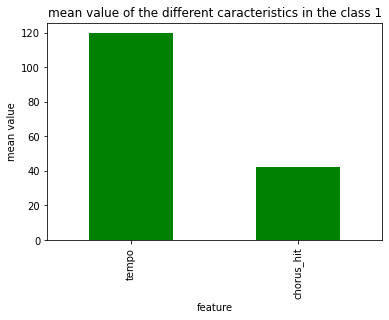

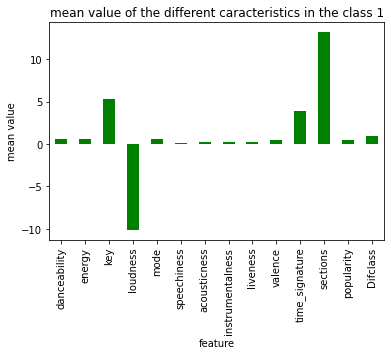

this is the description of the category 2
        danceability        energy  ...    popularity  Difclass
count  12399.000000  12399.000000  ...  12399.000000   12399.0
mean       0.543059      0.569687  ...      0.536495       2.0
std        0.168087      0.249540  ...      0.498686       0.0
min        0.000000      0.000276  ...      0.000000       2.0
25%        0.434000      0.379000  ...      0.000000       2.0
50%        0.554000      0.579000  ...      1.000000       2.0
75%        0.664000      0.778000  ...      1.000000       2.0
max        0.980000      1.000000  ...      1.000000       2.0

[8 rows x 17 columns]


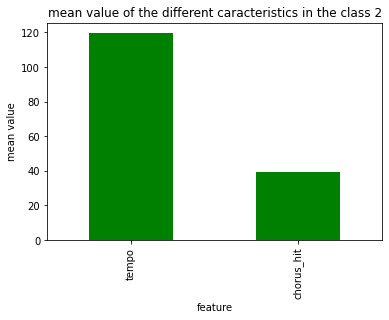

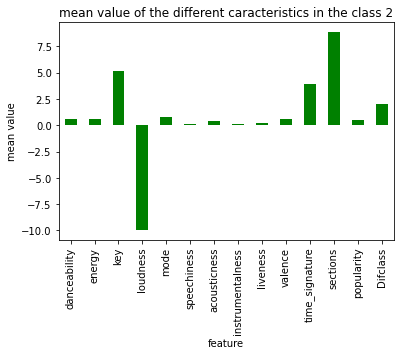

this is the description of the category 3
        danceability      energy         key  ...    sections  popularity  Difclass
count    477.000000  477.000000  477.000000  ...  477.000000  477.000000     477.0
mean       0.361174    0.429241    5.299790  ...   27.626834    0.071279       3.0
std        0.172731    0.272393    3.476853  ...    6.603662    0.257560       0.0
min        0.057600    0.000707    0.000000  ...    2.000000    0.000000       3.0
25%        0.223000    0.190000    2.000000  ...   23.000000    0.000000       3.0
50%        0.355000    0.421000    5.000000  ...   27.000000    0.000000       3.0
75%        0.479000    0.647000    9.000000  ...   31.000000    0.000000       3.0
max        0.870000    0.994000   11.000000  ...   53.000000    1.000000       3.0

[8 rows x 17 columns]


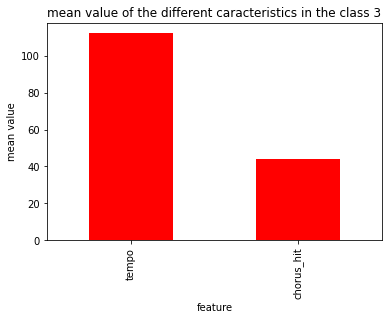

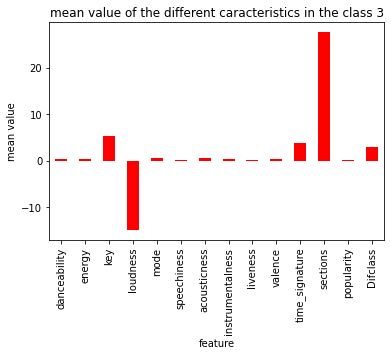

this is the description of the category 4
        danceability       energy  ...   popularity  Difclass
count   1982.000000  1982.000000  ...  1982.000000    1982.0
mean       0.484519     0.542750  ...     0.230575       4.0
std        0.203227     0.273925  ...     0.421307       0.0
min        0.059300     0.001500  ...     0.000000       4.0
25%        0.326250     0.329250  ...     0.000000       4.0
50%        0.478000     0.562000  ...     0.000000       4.0
75%        0.638750     0.765750  ...     0.000000       4.0
max        0.956000     0.999000  ...     1.000000       4.0

[8 rows x 17 columns]


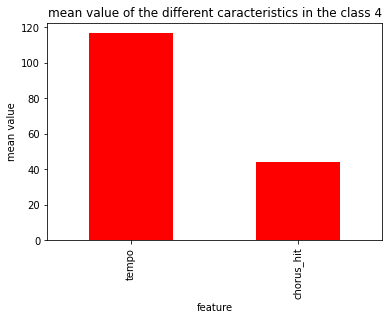

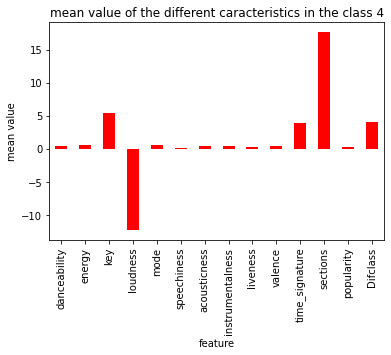

this is the description of the category 5
        danceability    energy        key  ...    sections  popularity  Difclass
count      7.000000  7.000000   7.000000  ...    7.000000         7.0       7.0
mean       0.425000  0.403966   5.857143  ...  116.142857         0.0       5.0
std        0.199326  0.245752   3.848314  ...   56.898824         0.0       0.0
min        0.157000  0.007660   0.000000  ...    0.000000         0.0       5.0
25%        0.284500  0.295050   3.500000  ...  105.000000         0.0       5.0
50%        0.492000  0.507000   7.000000  ...  130.000000         0.0       5.0
75%        0.541000  0.554000   8.000000  ...  152.000000         0.0       5.0
max        0.675000  0.615000  11.000000  ...  169.000000         0.0       5.0

[8 rows x 17 columns]


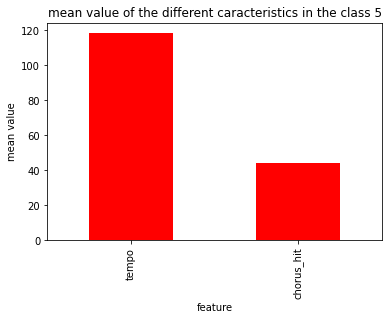

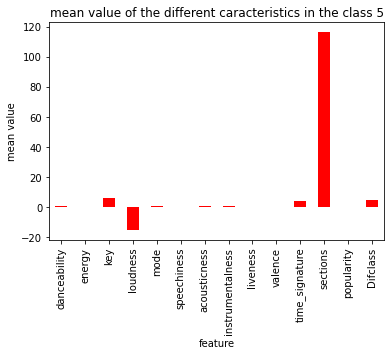

this is the description of the category 6
        danceability        energy  ...    popularity  Difclass
count  12568.000000  12568.000000  ...  12568.000000   12568.0
mean       0.569813      0.627588  ...      0.615691       6.0
std        0.171448      0.231109  ...      0.486451       0.0
min        0.059600      0.000357  ...      0.000000       6.0
25%        0.457000      0.475000  ...      0.000000       6.0
50%        0.582000      0.659000  ...      1.000000       6.0
75%        0.694000      0.812000  ...      1.000000       6.0
max        0.988000      0.999000  ...      1.000000       6.0

[8 rows x 17 columns]


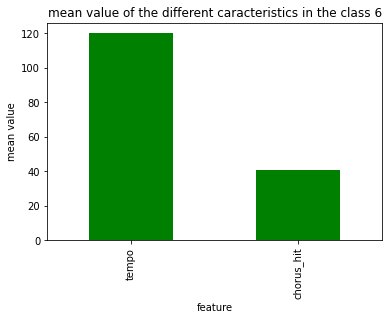

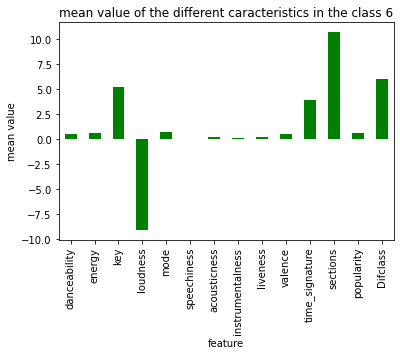

this is the description of the category 7
        danceability      energy         key  ...    sections  popularity  Difclass
count    126.000000  126.000000  126.000000  ...  126.000000  126.000000     126.0
mean       0.362553    0.396032    5.349206  ...   50.293651    0.031746       7.0
std        0.169925    0.238699    3.252857  ...   13.730007    0.176023       0.0
min        0.062900    0.001310    0.000000  ...   24.000000    0.000000       7.0
25%        0.228000    0.220000    3.000000  ...   41.250000    0.000000       7.0
50%        0.355500    0.368000    5.000000  ...   49.000000    0.000000       7.0
75%        0.461500    0.573750    8.000000  ...   57.000000    0.000000       7.0
max        0.748000    0.941000   11.000000  ...   97.000000    1.000000       7.0

[8 rows x 17 columns]


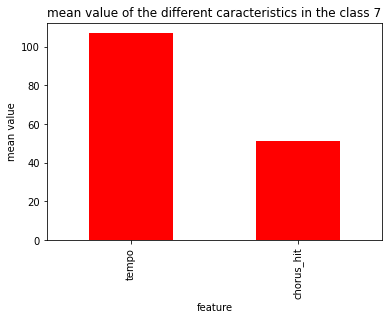

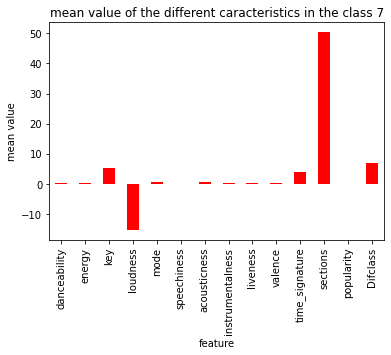

In [ ]:
pop=listmax[:3] #getting the 4 best represented popular song
for k in range(0,len(difclass)): #creating the loop on the number of different classes
  print('this is the description of the category '+ str(k) +'\n',difclass[k].describe()) #printing describe statistics about each class
  describe=difclass[k].describe() #creating a dataframe that take these informations
  describe=describe.drop(columns='duration_ms') #droping the columns with values that are much higher than the other
  plot1=describe.iloc[1][10:13].drop(index=['time_signature']) #dropping the value that are above 20
  labels = [f"{i}" for i in plot1.index.to_list()] #extracting the different labels
  if (k in pop)==True: #selecting the values depending on their representation of popular song if it is in the 4 first of listmax we will print it in green
    ax = plot1.plot(kind="bar",color='g')
  else : #if it is in the last 4 classes of listmax we will print it in red
    ax = plot1.plot(kind="bar",color='r')
  ax.set_title("mean value of the different caracteristics in the class " +str(k)) #setting x title
  ax.set_xlabel("feature") #setting x label
  ax.set_ylabel("mean value") #setting y label
  ax.set_xticklabels(labels) #setting x tick label as the name of the columns
  plt.show() #print the graph
  plot2=describe.drop(columns=['tempo','chorus_hit']) #dropping the columns above 20 in value
  Labels2 = [f"{i}" for i in plot2.columns.to_list()] #doing the same process as before
  if (k in pop)==True:
    ax = plot2.iloc[1].plot(kind="bar",color='g')
  else :
    ax = plot2.iloc[1].plot(kind="bar",color='r')
  ax.set_title("mean value of the different caracteristics in the class " +str(k))
  ax.set_xlabel("feature")
  ax.set_ylabel("mean value")
  ax.set_xticklabels(Labels2)
  plt.show()

Now that we have all the information to understand better our dataset, we can start to feed our predictive system, we will use different kind of Alogrithm in order to make our prediction and take the best model

We will first start by splitting the data into the training set and the testing set

In [ ]:
x = dfexp.drop(columns = "popularity") #getting all the input
y = dfexp["popularity"] #getting all the desired outputs
x_train, x_valid, y_train, y_valid = train_test_split(x,y,test_size=0.3, stratify=y) #splitting the dataset into the training and validation set by stratifing it in order to keep it balanced

We will first create a list that will contain all our model that had the best hyperparameter this list will be called Modellist

In [ ]:
Modellist=[] #creating the empty list that will contain our models

SGD Classifier 

In [ ]:
# grid_search = GridSearchCV(SGDClassifier(random_state=42, max_iter=15000), #creating the grid search
#                           { 'alpha':np.arange(0.00000001,0.0001,0.0000001)  #creating the list of alpha that will change in the training                     
#                            },cv=2, scoring="r2",verbose=1,
#                           )
# grid_search.fit(x_train,y_train) #training the grid search on the different hyperparameters

Since the cell besides has taken 9 minutes to load i will show you the result with a screenshot : 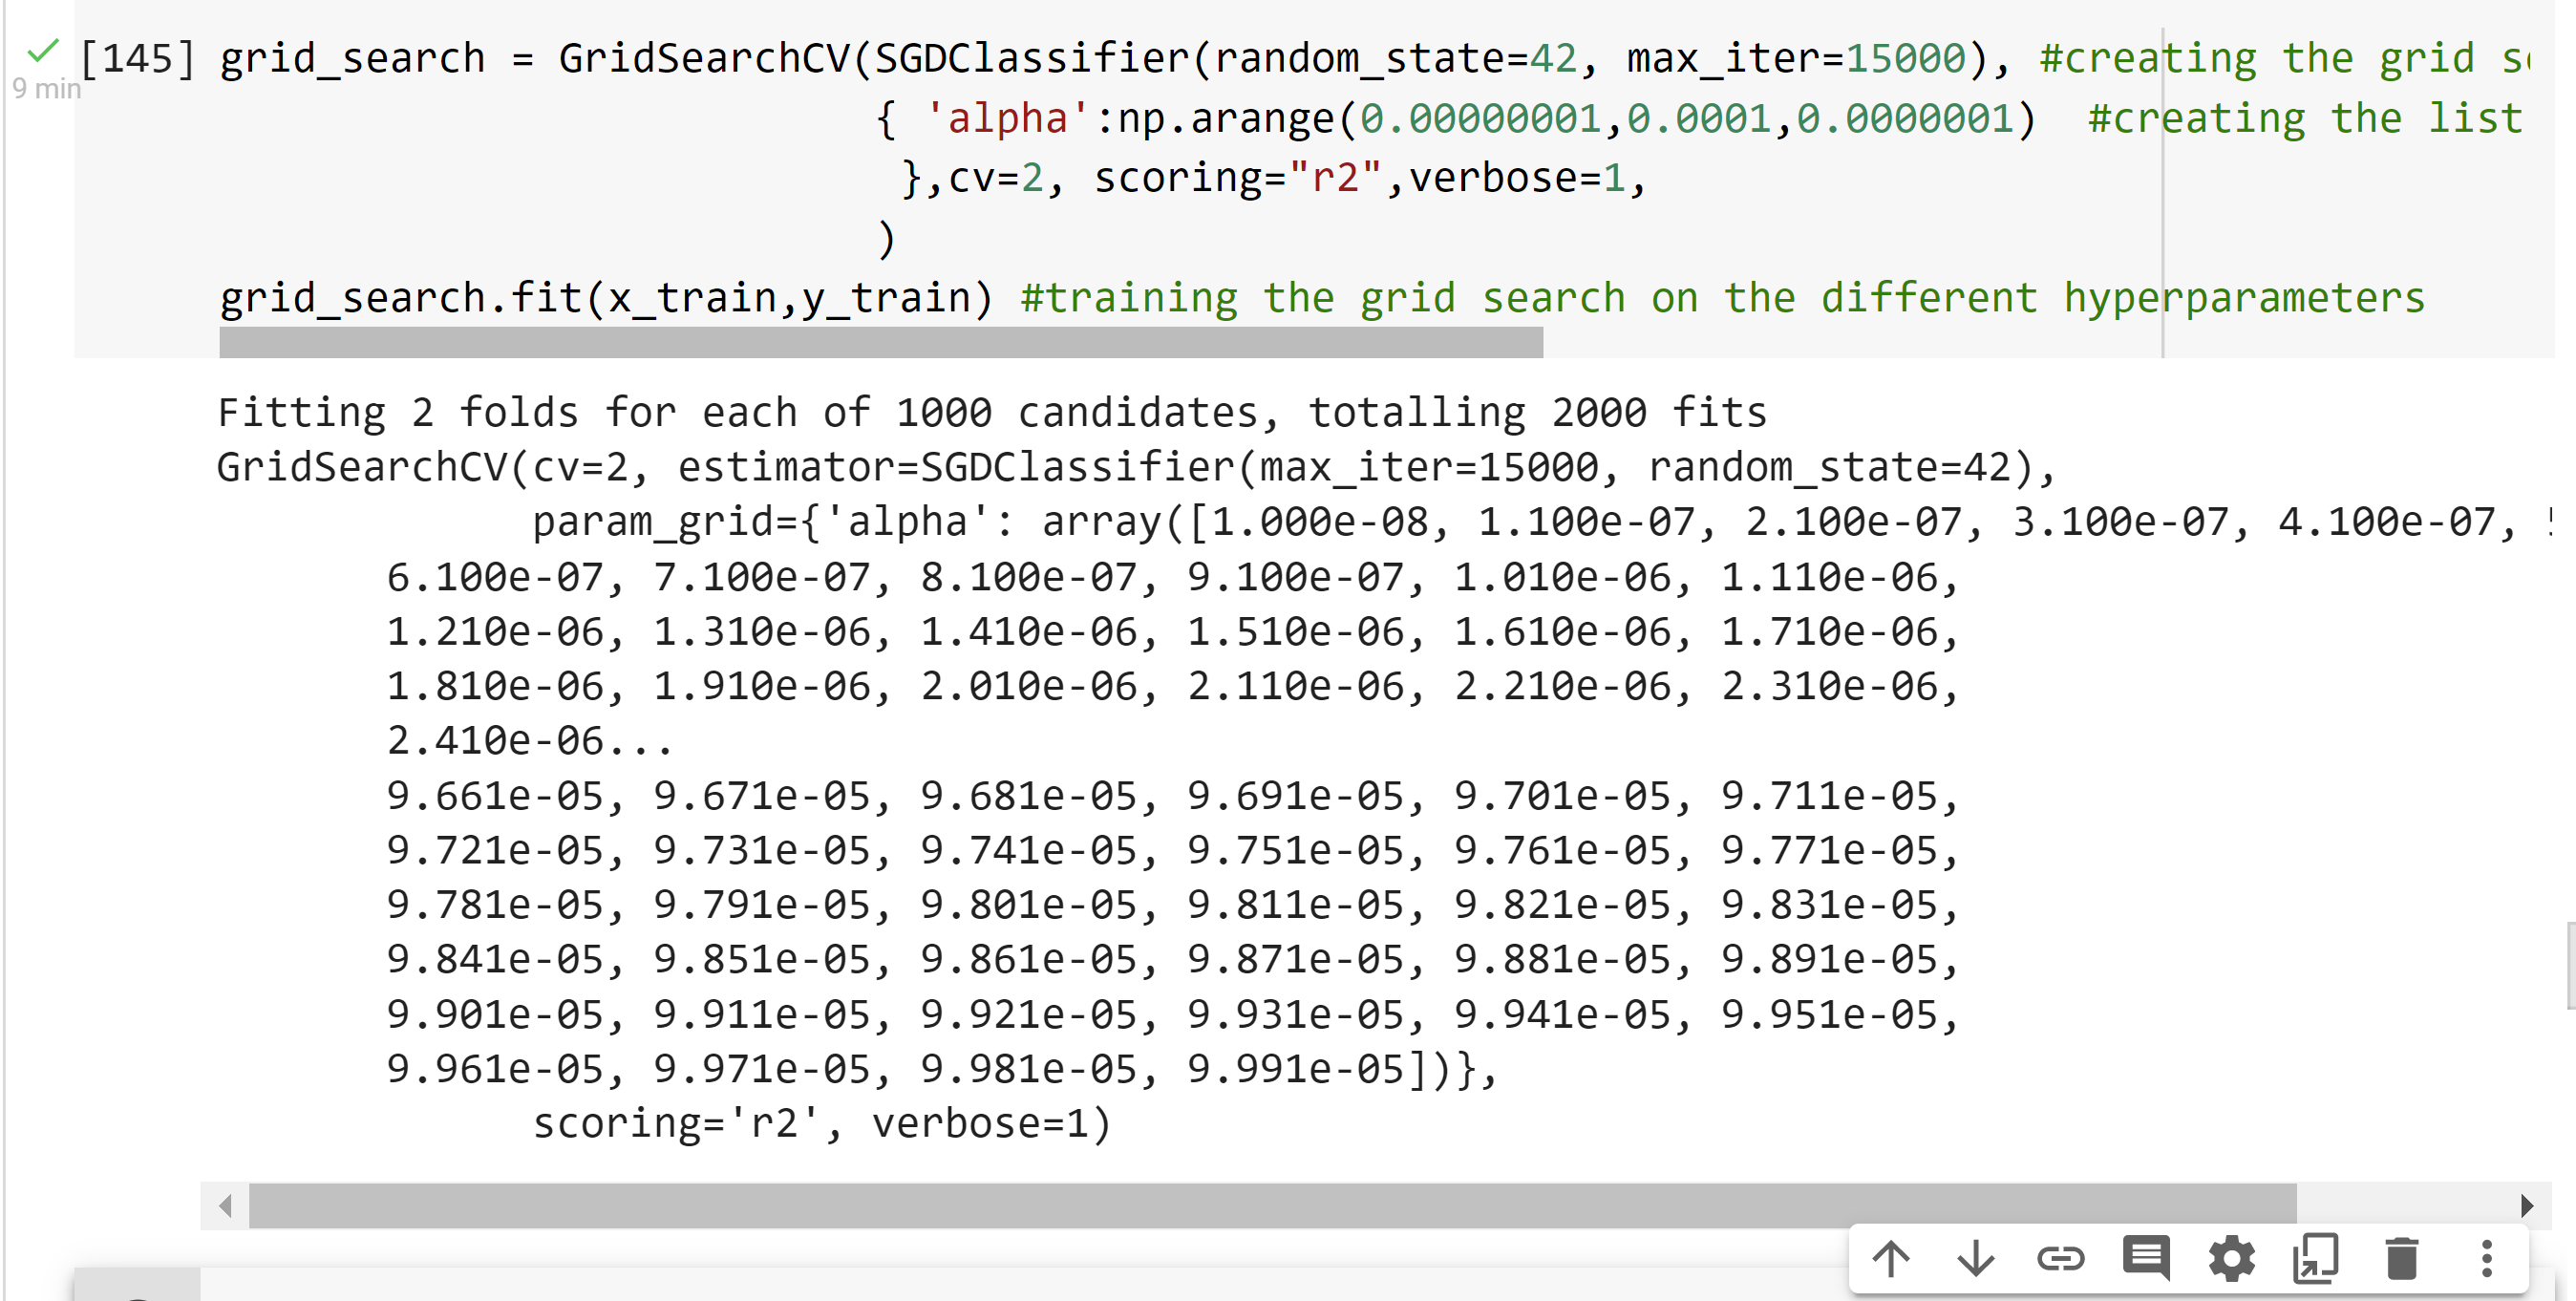

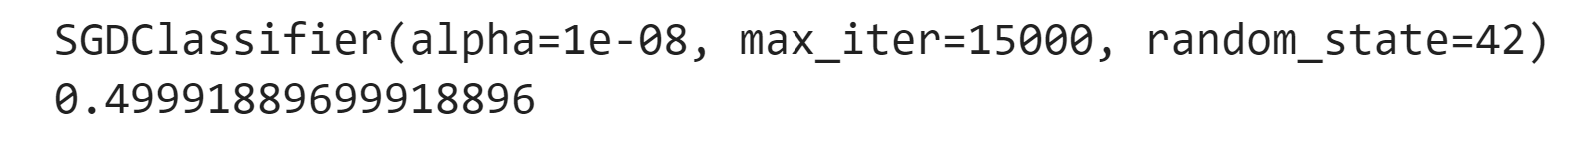

In [ ]:
grid_searchbest_estimator_=SGDClassifier(alpha=1e-08, max_iter=15000, random_state=42) #setting the best estimator 

In [ ]:
modsgd= grid_searchbest_estimator_ #attributing the best estimator value
#modsgd= grid_search.best_estimator_ #code to take if you recompute everything
modsgd.fit(x_train, y_train) #fitting the estimator
modsgd_pred = modsgd.predict(x_valid) # making the prediction based on the SGDClassifier
print(accuracy_score(y_valid, modsgd_pred)) #printing accuracy
Modellist.append(modsgd) #appending the model to the list of models

0.5


In [ ]:
def tuningknn(Nclass): #creating the tunning visualization
  Acc=[] #creating an empty accuracy list
  nc=[]  #creating an empty n-neighbors list count
  for k in range(1, Nclass,100): #creating a loop
    knn=KNeighborsClassifier(n_neighbors=k, weights='distance', n_jobs=-1) #training the knn with a changing number of neighbors
    knn.fit(x_train,y_train) #fitting the model
    knn_pred=knn.predict(x_valid) #making prediciton
    Acc.append(accuracy_score(y_valid, knn_pred)) #computing accuracy and appending it to Acc
    nc.append(k) #append n-neighbors for this model
  plt.plot(nc,Acc) #ploting the different x and y
  plt.title('Accuracy in function of the number of neighbors') #changing the title
  plt.show() #showing the model



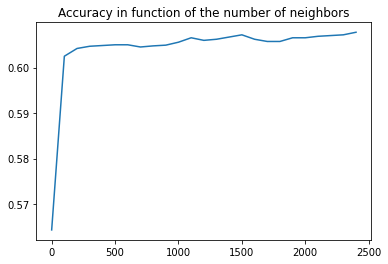

In [ ]:
tuningknn(2500) #tuningknn for different neighbors value

Since the tunning show us that there seem to be an asymptot close to 0.60 when we are on a number of neighbors higher than 500, we can approximate the best estimator as the one with n_neighbors at 500.

In [ ]:
grid_params= { #setting up the grid parameters
              'n_neighbors':np.arange(1,1000,10) #changing the different neighbors parameters
              }
gridsearch2 =GridSearchCV(KNeighborsClassifier(), #applying the grid search method
                          grid_params,  #selecting our grid params
                          n_jobs=-1)
#gridsearch2.fit(x_train,y_train) #fitting the gridsearch

In [ ]:
#print(gridsearch2.best_estimator_) #get the best estimator values

Same issue as before, i will make them into comment but you can run it if you want, here is the screenshot : 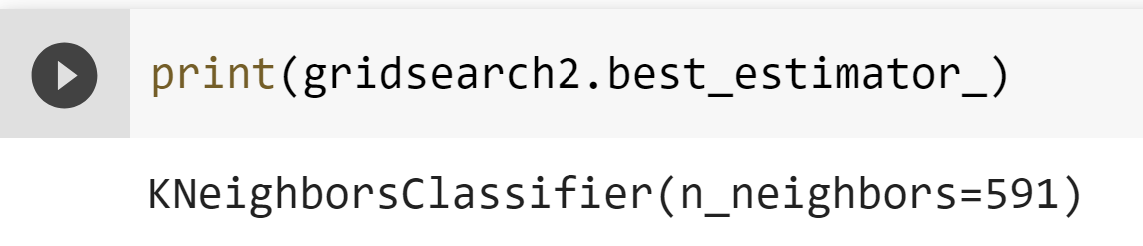

In [ ]:
knn=KNeighborsClassifier(n_neighbors=591, weights='distance', n_jobs=-1) #training the model with the best estimator
knn.fit(x_train,y_train) #fitting the model
knn_pred = knn.predict(x_valid) #making prediction
print(accuracy_score(y_valid, knn_pred)) #printing accuracy of the model
Modellist.append(knn) #appending the model to the model's list

0.605190592051906


In [ ]:
param_grid = { #creating the parameter grid
    'bootstrap': [True], #selecting bootstrap
    'max_depth': np.arange(1,100,6), #creating the list of max depth
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
}

rf = RandomForestClassifier() #creating the random forest
# Instantiate the grid search model
grid_searchrf = GridSearchCV(estimator = rf, param_grid = param_grid, n_jobs = -1, verbose = 2) #applying grid search method

In [ ]:
#grid_searchrf.fit(x_train,y_train) #fitting gridsearch
#print(grid_searchrf.best_estimator_) #printing the best estimator

For the same reason as before i will take the result of the previous cell and make it as a commentary 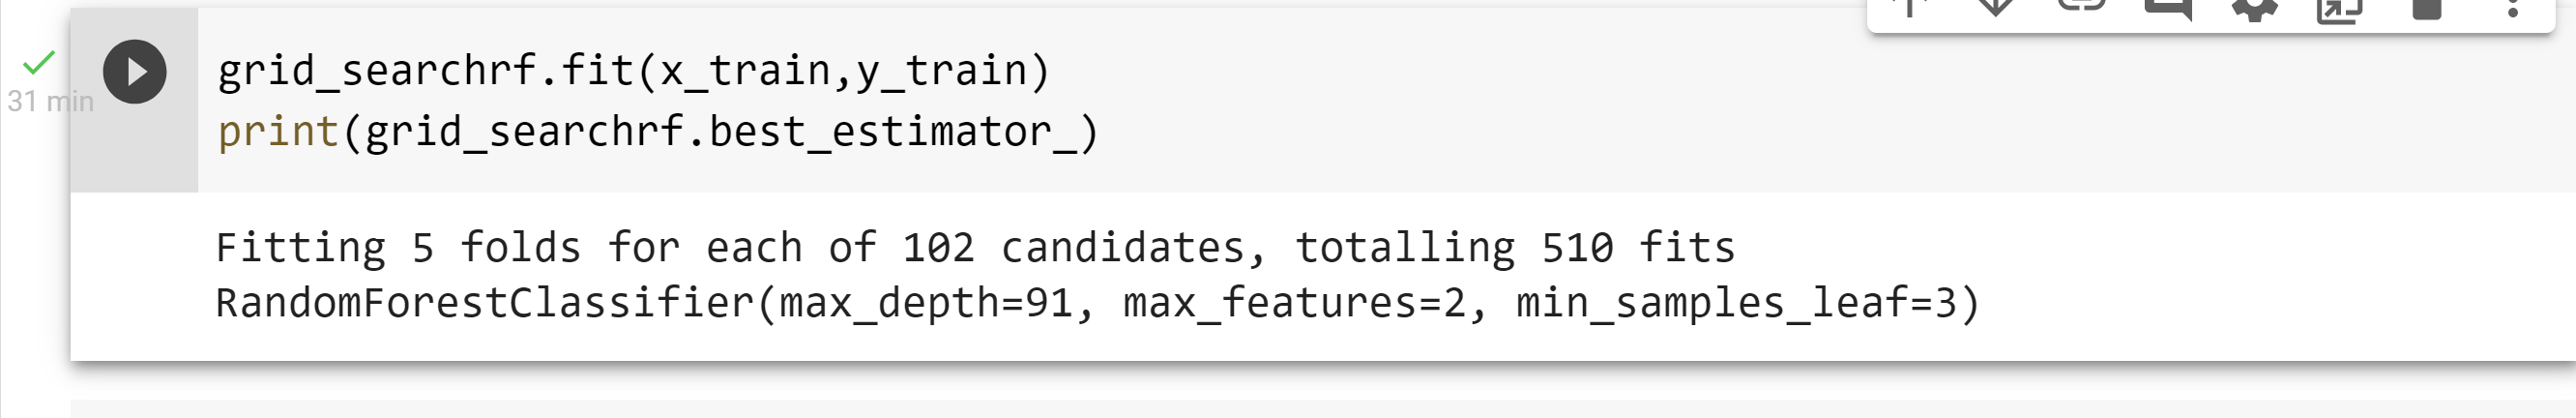

In [ ]:
rfbestmod=RandomForestClassifier(max_depth=91,max_features=2,min_samples_leaf=3,random_state=42) #trying the best model
rfbestmod.fit(x_train, y_train) #fitting the model
rfbestmod_pred = rfbestmod.predict(x_valid) #making prediction
print(accuracy_score(y_valid, rfbestmod_pred)) #printing accuracy
Modellist.append(rfbestmod) #appending the model to the model's list

0.7802919708029197


In [ ]:
params = {'max_depth': list(range(2, 40)), 'min_samples_leaf': list(range(2,20))} #setting up parameters

grid_search_cvdestree = GridSearchCV(DecisionTreeClassifier(), #creating the grid search with our parameters
                             params, 
                              verbose=1, 
                              cv=3,
                              n_jobs = -1,)

In [ ]:
#grid_search_cvdestree.fit(x_train, y_train) #training the gridsearch

Since the cell beside was run for 3 hours i have choosen to make it as a commentary and only use the result, if you want to run it on your own you will have to uncomment

In [ ]:
#print(grid_search_cvdestree.best_estimator_) #printing the best estimator
bestmod=DecisionTreeClassifier(max_depth=7,min_samples_leaf=9,random_state=42) #creating the model
bestmod.fit(x_train, y_train) #fitting the model
bestmod_pred = bestmod.predict(x_valid) #making prediction
print(accuracy_score(y_valid, bestmod_pred)) #printing accuracy
Modellist.append(bestmod) #append the model to the model's list

0.7503649635036497


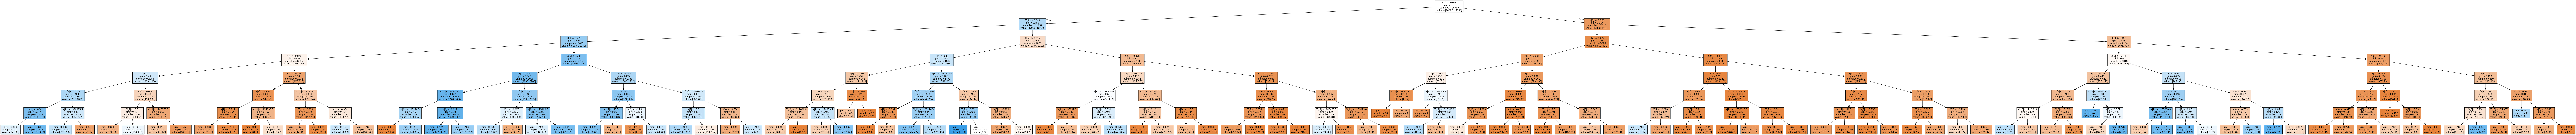

In [ ]:
export_graphviz(bestmod,out_file=("bestdecisiontreeclassifier.dot"),feature_names=None,class_names=None,filled=True) #visualizing the Decision Tree
!dot -Tpng bestdecisiontreeclassifier.dot -o bestdecisiontreeclassifier.png #converting .dot into png
Image("bestdecisiontreeclassifier.png") #display the decision tree

Interpretation of the results

Now that we have choosen the best models for each type of algorithms, we will focus on choosing the best one between the different we will use accuracy, ROC curve and AUC

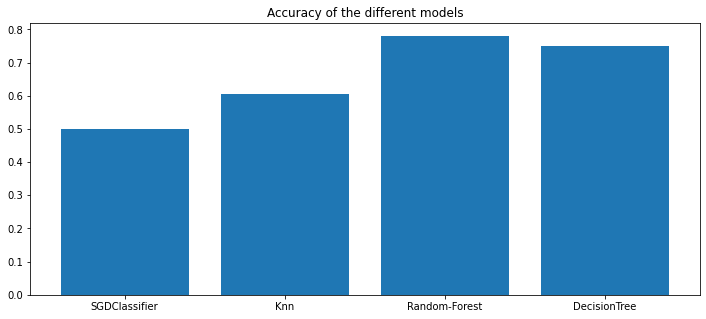

In [ ]:
plt.figure(figsize=(12, 5)) #creating the figure
ax1 = plt.subplot() #setting axis
x=[1,2,3,4] #setting up the x ticks
ax1.set_xticks(x)
Modellistacc=[] #creating an empty list that will contain the different accuracy
for k in range(len(Modellist)): #creating the loop to compute accuracy
  Modellistacc.append(accuracy_score(y_valid,Modellist[k].predict(x_valid))) #append the list with the accuracy of the kth model
ax1.set_xticklabels(["SGDClassifier","Knn","Random-Forest","DecisionTree"]) #setting up the different labels
ax1.set_title('Accuracy of the different models') #changing the tittle
plt.bar([i for i in range(1,5)],Modellistacc) #ploting the different bars
plt.savefig('Accuracy of the models',dpi=300) #saving the figure
plt.show() #showing the figure

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. U

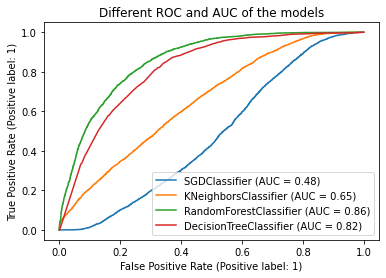

In [ ]:
disp=plot_roc_curve(Modellist[0], x_valid, y_valid) #creating the display of the different model and plotting their auc and roc curve
plot_roc_curve(Modellist[1], x_valid, y_valid,ax=disp.ax_);
plot_roc_curve(Modellist[2], x_valid, y_valid,ax=disp.ax_)
plot_roc_curve(Modellist[3], x_valid, y_valid,ax=disp.ax_)
disp.ax_.set_title("Different ROC and AUC of the models") #setting the tittle
plt.savefig('ROCrecap',dpi=300) #saving figures

SGDClassifier(alpha=1e-08, max_iter=15000, random_state=42)


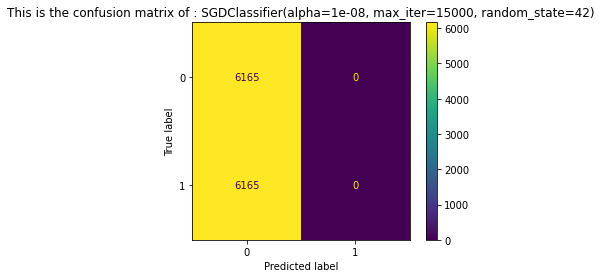

KNeighborsClassifier(n_jobs=-1, n_neighbors=591, weights='distance')


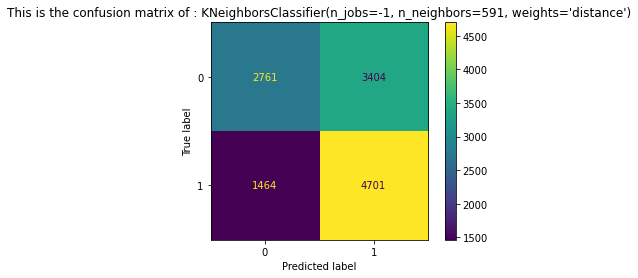

RandomForestClassifier(max_depth=91, max_features=2, min_samples_leaf=3,
                       random_state=42)


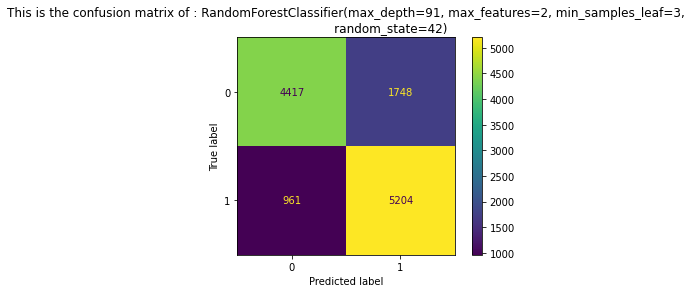

DecisionTreeClassifier(max_depth=7, min_samples_leaf=9, random_state=42)


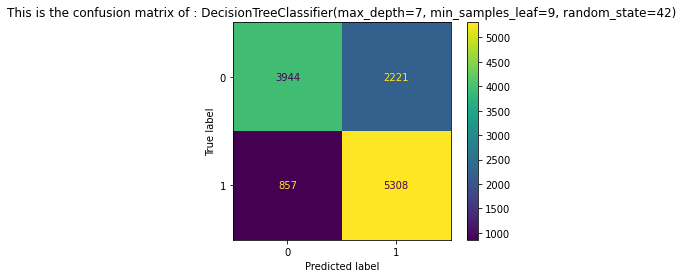

In [ ]:
for k in range(len(Modellist)): #creating the loop to comput confusion matrix for each model
  print(Modellist[k]) #printing the name of the model
  predictions = Modellist[k].predict(x_valid) #making the prediction
  cm = confusion_matrix(y_valid, predictions, labels=Modellist[k].classes_) #computing the confusion matrix
  disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=Modellist[k].classes_) #displaying the different inforamtions
  disp.plot() #ploting the display
  disp.ax_.set_title("This is the confusion matrix of : " +str(Modellist[k])) #changing the title
  plt.savefig('disp'+str(k),dpi=300) #saving figure
  plt.show() #showing the plot

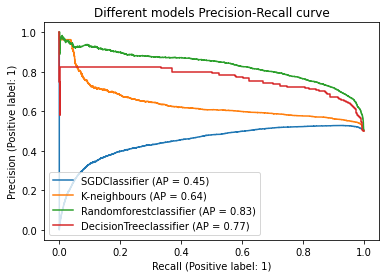

In [ ]:
displa = PrecisionRecallDisplay.from_estimator(Modellist[0], x_valid, y_valid, name="SGDClassifier") #creating the different curves
PrecisionRecallDisplay.from_estimator(Modellist[1], x_valid, y_valid,ax=displa.ax_,name="K-neighbours");
PrecisionRecallDisplay.from_estimator(Modellist[2], x_valid, y_valid,ax=displa.ax_,name="Randomforestclassifier")
PrecisionRecallDisplay.from_estimator(Modellist[3], x_valid, y_valid,ax=displa.ax_,name="DecisionTreeclassifier")
displa.ax_.set_title("Different models Precision-Recall curve") #changing the title
plt.savefig('display',dpi=300) #saving figure

Since our Random forest classifier has the best ROC-AUC score, best accuracy and best Precision recall curve,  we will take this one for sure as the best predictive model developped here ! Thank you for the time you have taken to go through this notebook ! 

This work was produced by Julien Séailles !